In [1]:
import random
from typing import TypedDict, List, Annotated
import operator
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

**Data Processing**

In [2]:
class State(TypedDict):
    input: int
    partial: Annotated[List[int], operator.add]
    results: Annotated[List[int], operator.add]

In [3]:
def node_a(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['input'] + partial
    print(
        f"NODE A:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [4]:
def node_b(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['results'][-1] + partial
    print(
        f"NODE B:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [5]:
workflow = StateGraph(State)

In [6]:
workflow.add_node(node_a)
workflow.add_node(node_b)

In [7]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

In [8]:
graph = workflow.compile()

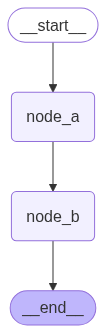

In [9]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [10]:
config = {"configurable": {"offset": 20}}
graph.invoke(
    input = {
        "input": 1,
    }, 
    config = config,
)

NODE A:
 ->input:1
 ->offset:20
 ->random:6
 ->partial:26
 ->output:27
 
NODE B:
 ->input:27
 ->offset:20
 ->random:8
 ->partial:28
 ->output:55
 


{'input': 1, 'partial': [26, 28], 'results': [27, 55]}

**Call LLMs**

In [11]:
import os
llm = ChatOpenAI(
  api_key=os.getenv("OPENROUTER_API_KEY"),
  base_url=os.getenv("OPENROUTER_BASE_URL"),
  model="openai/gpt-oss-20b:free",
  default_headers={
    # "HTTP-Referer": getenv("YOUR_SITE_URL"),
    # "X-Title": getenv("YOUR_SITE_NAME"),
  }
)

In [12]:
# from dotenv import load_dotenv
# load_dotenv()
# llm = ChatOpenAI(
#     model="gpt-4o-mini",
#     temperature=0.0,
# )

In [13]:
class State(MessagesState):
    question:str

In [14]:
def model(state: State, config: RunnableConfig):
    question = state["question"]
    messages = state["messages"]
    name = None
    if config:
        name = config["configurable"].get("name")

    if name and not messages:
        messages.append(
            SystemMessage(
                "Help the following user. \n"
                f"Name={name} \n"
                "Give an initial greeting before responding."
            )
        )

    messages.append(HumanMessage(question))
    response = llm.invoke(messages)
    messages.append(response)

    return {"messages": messages}

In [15]:
workflow = StateGraph(State)

In [16]:
workflow.add_node("model", model)

In [17]:
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

In [18]:
graph = workflow.compile()

In [19]:
result = graph.invoke(
    input={"question": "What's the name of Ash's first pokémon?"}, 
    config={"configurable": {"name": "James"}}
)

In [20]:
for message in result['messages']:
    message.pretty_print()

================================ System Message ================================

Help the following user. 
Name=James 
Give an initial greeting before responding.
================================ Human Message =================================

What's the name of Ash's first pokémon?
================================== Ai Message ==================================

Hello, James! Ash’s first Pokémon is **Pikachu**.
